[@gzuidhof][1] 's [tutorial][2] inspired me a lot. So, I tried to experiment on segmenting lungs.

  [1]: https://www.kaggle.com/gzuidhof
  [2]: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import os
import glob
import cv2

# Imaging libraries
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#p = sns.color_palette()
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Pandas configuration
pd.set_option('display.max_columns', None)
print('OK.')
print(cv2.__version__)

OK.
3.2.0-dev


In [2]:
# get patients list
import dicom
dicom_root = '../input/sample_images/'
patients = [ x for x in os.listdir(dicom_root) if len(x)==32 ]
print('Patient count: {}'.format(len(patients)))

Patient count: 20


Now, try to correct DICOM rescaling the right way. Load patient function will give rescaling applied slices.

In [3]:
# DICOM rescale correction
def rescale_correction(s):
    s.image = s.pixel_array * s.RescaleSlope + s.RescaleIntercept

# Returns a list of images for that patient_id, in ascending order of Slice Location
# The pre-processed images are stored in ".image" attribute
def load_patient(patient_id):
    files = glob.glob(dicom_root + '/{}/*.dcm'.format(patient_id))
    slices = []
    for f in files:
        dcm = dicom.read_file(f)
        rescale_correction(dcm)
        # TODO: spacing eq.
        slices.append(dcm)
    
    slices = sorted(slices, key=lambda x: x.SliceLocation)
    return slices

Now, try to segment and visualise some lungs...

0d941a3ad6c889ac451caf89c46cb92a


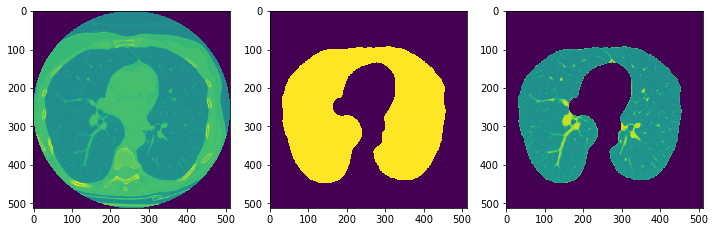

0de72529c30fe642bc60dcb75c87f6bd


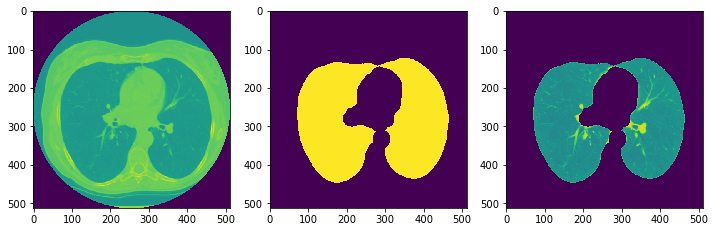

0c98fcb55e3f36d0c2b6507f62f4c5f1


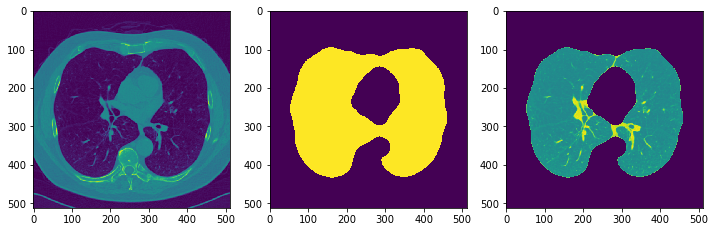

0a38e7597ca26f9374f8ea2770ba870d


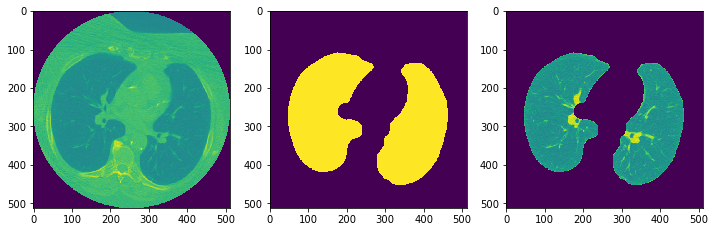

0d19f1c627df49eb223771c28548350e


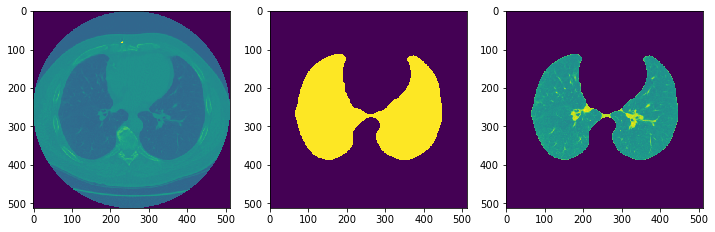

0c0de3749d4fe175b7a5098b060982a1


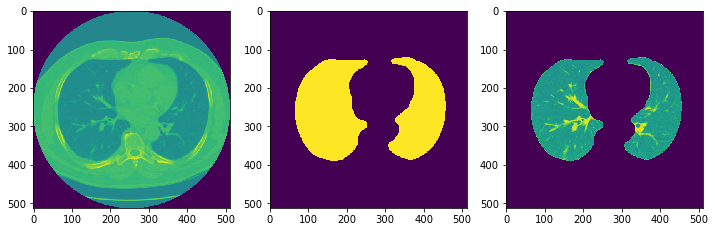

0ddeb08e9c97227853422bd71a2a695e


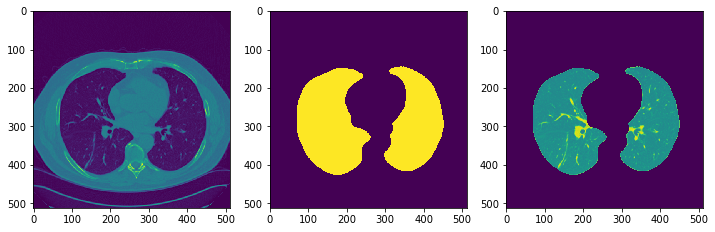

0c60f4b87afcb3e2dfa65abbbf3ef2f9


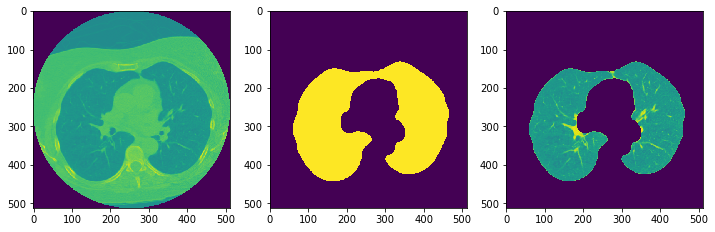

0c37613214faddf8701ca41e6d43f56e


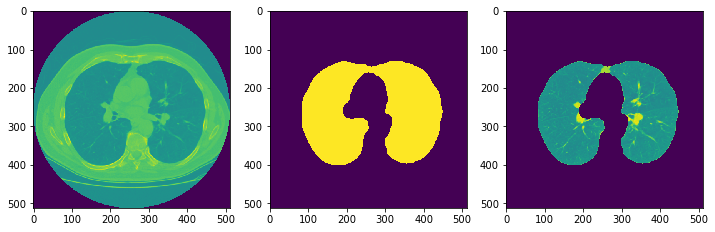

00cba091fa4ad62cc3200a657aeb957e


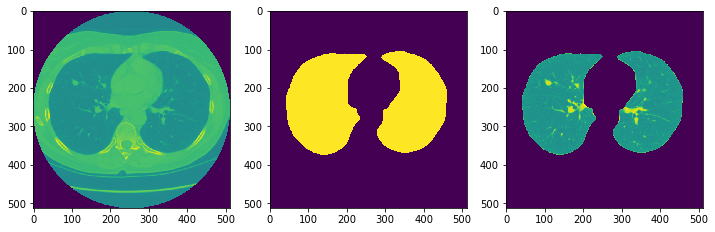

0d2fcf787026fece4e57be167d079383


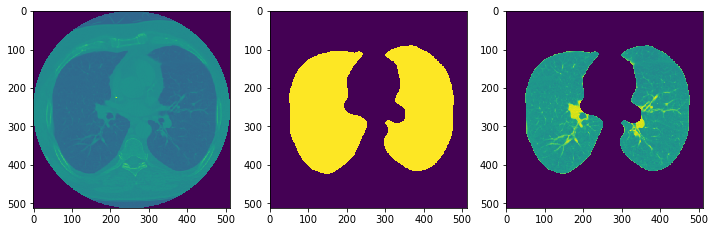

0c9d8314f9c69840e25febabb1229fa4


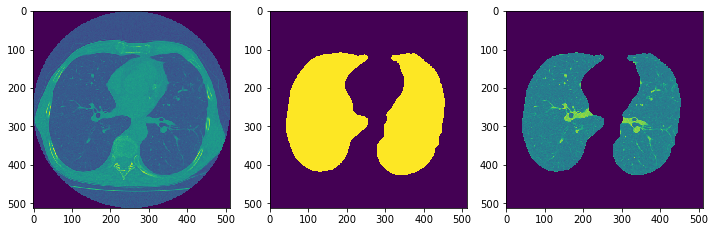

0d06d764d3c07572074d468b4cff954f


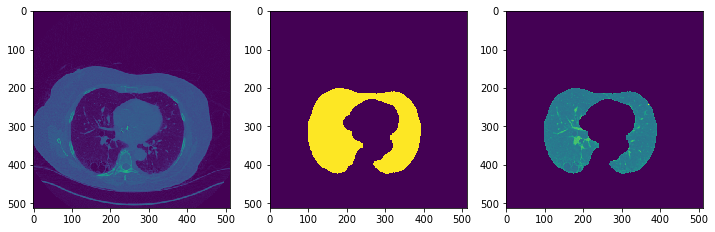

0acbebb8d463b4b9ca88cf38431aac69


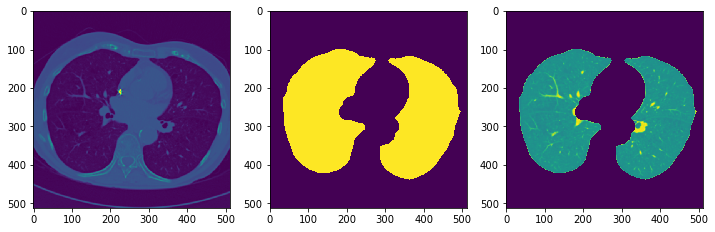

0a0c32c9e08cc2ea76a71649de56be6d


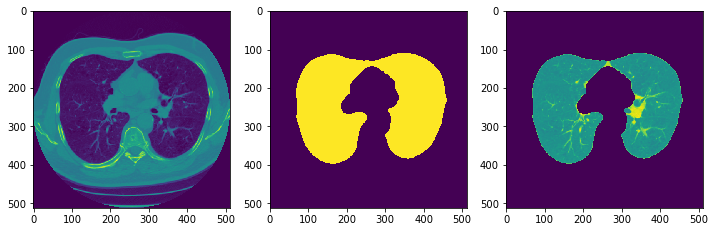

0b20184e0cd497028bdd155d9fb42dc9


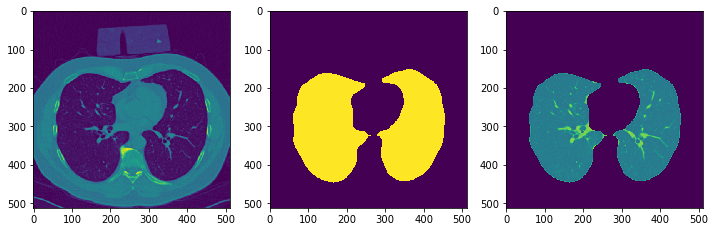

0a099f2549429d29b32f349e95fb2244


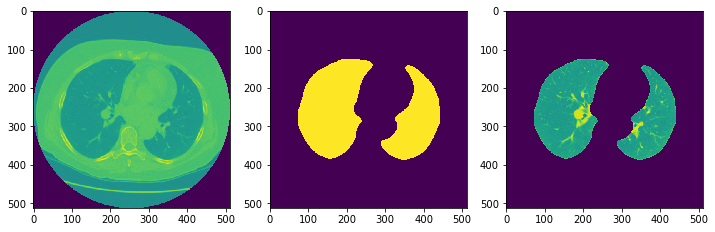

0ca943d821204ceb089510f836a367fd


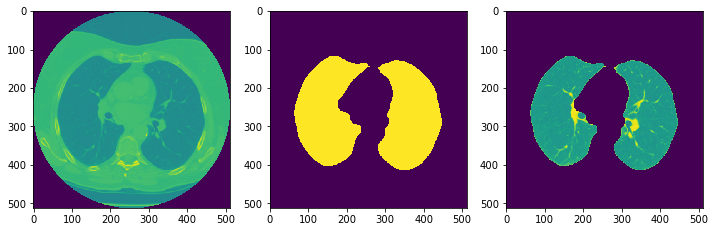

0bd0e3056cbf23a1cb7f0f0b18446068


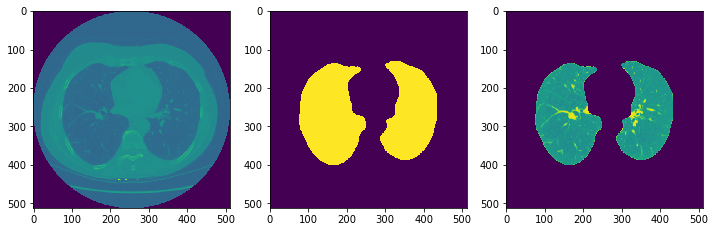

0c59313f52304e25d5a7dcf9877633b1


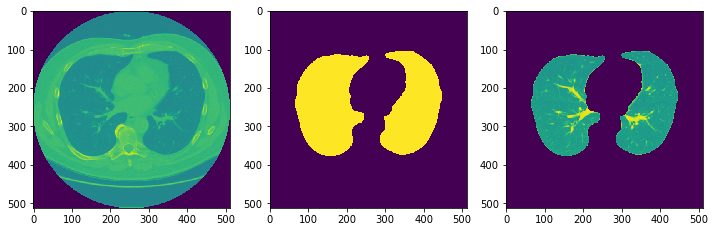

In [4]:
# Load a patient
for patient_no in patients:
    pat = load_patient(patient_no)
    print(patient_no)

    img = pat[ int(len(pat)/2) ].image.copy()

    # threshold HU > -300
    img[img>-300] = 255
    img[img<-300] = 0
    img = np.uint8(img)

    # find surrounding torso from the threshold and make a mask
    im2, contours, _ = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(mask, [largest_contour], 255)

    # apply mask to threshold image to remove outside. this is our new mask
    img = ~img
    img[(mask == 0)] = 0 # <-- Larger than threshold value

    # apply closing to the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    
    # apply mask to image
    img2 = pat[ int(len(pat)/2) ].image.copy()
    img2[(img == 0)] = -2000 # <-- Larger than threshold value

    # closing
    #sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    #largest_contour = max(contours, key=cv2.contourArea)
    #rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    #aaa = np.concatenate( sorted_contours[1:3] )
    #cv2.drawContours(rgb, [cv2.convexHull(aaa)], -1, (0,255,0), 3)

    plt.figure(figsize=(12, 12))
    plt.subplot(131)
    plt.imshow(pat[ int(len(pat)/2) ].image)
    plt.subplot(132)
    plt.imshow(img)
    plt.subplot(133)
    plt.imshow(img2)
    plt.show()

Please note that, OpenCV libraries are faster then the ones on skimage. Not every feature is here or there, so both libraries are useful for me. But I prefer OpenCV for image processing. 

That's it for now. Please comment where to go from here to further. What should I do next?

Thank you!